In [1]:
import os

import numpy as np
from scipy.stats import sem
import seaborn as sns
import matplotlib.pyplot as plt
import gymnasium as gym

import gym_env
from utils import decision_policy, update_terminal_reward, policy_reval, softmax
from utils_render import plot_decision_prob
from models import SR_IS, SR_TD

In [ ]:
# Hyperparams
reward = -0.1
alpha = 0.05
beta = 1.0
num_steps = 40000
num_iterations = 10
term_reward = 10
old_reward = 10
new_reward = 20
env = "maze-11x11-two-goal"

# For plotting
colors = [1, 9]
g1 = 4
g2 = 69
prob_point = 36
prob_locs = [29, 43]

# Save dir
save_dir = os.path.join('..', 'figures/')

## Policy Revaluation

### Complete Model

In [3]:
prob_old_complete, prob_new_complete = [[], []], [[], []]

for i in range(num_iterations):
    print(f"Iteration: {i+1}")
    np.random.seed(i)
    linear_rl = SR_IS(env_name=env, reward=reward, term_reward=reward, alpha=alpha, beta=beta, 
                num_steps=num_steps, policy="softmax", imp_samp=True)
    
    update_terminal_reward(linear_rl, loc=0, r=old_reward)
    
    D_inv = linear_rl.get_D_inv()
    linear_rl.DR = D_inv
    linear_rl.update_V()
    pii_old_complete = decision_policy(linear_rl, linear_rl.Z)
    probs_old_complete = pii_old_complete[prob_point, prob_locs]
    probs_old_complete = probs_old_complete / np.sum(probs_old_complete)

    # print(pii_old_complete[28,23], pii_old_complete[28,34])

    update_terminal_reward(linear_rl, loc=1, r=new_reward)

    # Version 2
    # D_inv = linear_rl.get_D_inv()
    # linear_rl.DR = D_inv
    # linear_rl.update_V()
    # pii_new_complete = decision_policy(linear_rl, linear_rl.Z)

    # Version 1
    V_new, Z_new = policy_reval(linear_rl)
    pii_new_complete = decision_policy(linear_rl, Z_new)
    probs_new_complete = pii_new_complete[prob_point, prob_locs]
    probs_new_complete = probs_new_complete / np.sum(probs_new_complete)

    # print(pii_new_complete[28,23], pii_new_complete[28,34])

    prob_old_complete[0].append(probs_old_complete[0])
    prob_old_complete[1].append(probs_old_complete[1])
    prob_new_complete[0].append(probs_new_complete[0])
    prob_new_complete[1].append(probs_new_complete[1])

    # prob_old_complete[0].append(pii_old_complete[28,23])
    # prob_old_complete[1].append(pii_old_complete[28,34])
    # prob_new_complete[0].append(pii_new_complete[28,23])
    # prob_new_complete[1].append(pii_new_complete[28,34])

Iteration: 1


Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10


### TD Models

In [4]:
prob_old_sr_is, prob_new_sr_is = [[], []], [[], []]
prob_old_sr_mb, prob_new_sr_mb = [[], []], [[], []]

for i in range(num_iterations):
    print(f"Iteration {i+1}")
    np.random.seed(i)
    sr_is = SR_IS(env_name=env, reward=reward, term_reward=reward, alpha=alpha, beta=beta, 
                num_steps=num_steps, policy="softmax", imp_samp=True)
    sr_mb = SR_IS(env_name=env, reward=reward, term_reward=reward, alpha=alpha, beta=beta, 
                num_steps=num_steps, policy="softmax", imp_samp=False)

    update_terminal_reward(sr_is, loc=0, r=old_reward)
    update_terminal_reward(sr_mb, loc=0, r=old_reward)

    ## Learn current terminal reward structure and get current policy
    sr_is.learn(seed=int(i))
    sr_mb.learn(seed=int(i))

    pii_old_sr_is = decision_policy(sr_is, sr_is.Z)
    pii_old_sr = decision_policy(sr_mb, sr_mb.Z)

    ## Update terminal states and get new policy
    # SR-IS
    update_terminal_reward(sr_is, loc=1, r=new_reward)
    V_new, Z_new = policy_reval(sr_is)
    pii_new_sr_is = decision_policy(sr_is, Z_new)

    probs_old_sr_is = pii_old_sr_is[prob_point, prob_locs]
    probs_old_sr_is = probs_old_sr_is / np.sum(probs_old_sr_is)

    probs_new_sr_is = pii_new_sr_is[prob_point, prob_locs]
    probs_new_sr_is = probs_new_sr_is / np.sum(probs_new_sr_is)

    prob_old_sr_is[0].append(probs_old_sr_is[0])
    prob_old_sr_is[1].append(probs_old_sr_is[1])
    prob_new_sr_is[0].append(probs_new_sr_is[0])
    prob_new_sr_is[1].append(probs_new_sr_is[1])

    # prob_old_sr_is[0].append(pii_old_sr_is[28,23])
    # prob_old_sr_is[1].append(pii_old_sr_is[28,34])
    # prob_new_sr_is[0].append(pii_new_sr_is[28,23])
    # prob_new_sr_is[1].append(pii_new_sr_is[28,34])

    # SR-MB
    sr_mb_r_old = np.full_like(sr_mb.r, fill_value=0)
    sr_mb_r_old[g1] = old_reward
    sr_mb_r_new = np.copy(sr_mb_r_old)
    sr_mb_r_new[g2] = new_reward
    

    I = np.eye(sr_mb.size)
    SR_Inv = np.linalg.inv(I-sr_mb.gamma*pii_old_sr)

    V_old = SR_Inv @ sr_mb_r_old
    V_new = SR_Inv @ sr_mb_r_new
    
    probs_old_sr_mb = softmax(x=np.array([V_old[prob_locs[0]], V_old[prob_locs[1]]]), temperature=1)
    probs_new_sr_mb = softmax(x=np.array([V_new[prob_locs[0]], V_new[prob_locs[1]]]), temperature=1)
    prob_old_sr_mb[0].append(probs_old_sr_mb[0])
    prob_old_sr_mb[1].append(probs_old_sr_mb[1])
    prob_new_sr_mb[0].append(probs_new_sr_mb[0])
    prob_new_sr_mb[1].append(probs_new_sr_mb[1])

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


### Plot decision probs at key point

#### Complete Model

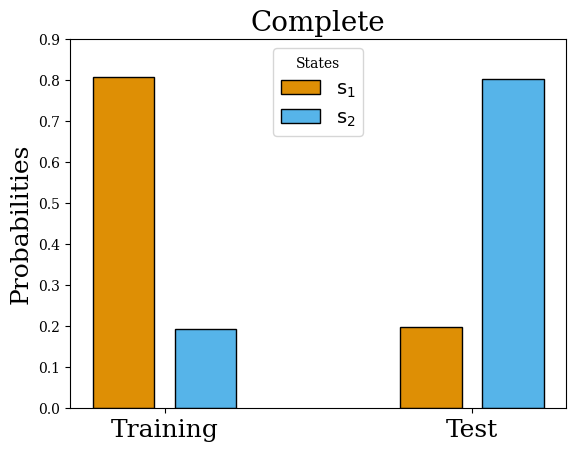

In [ ]:
save_path = save_dir + 'policy_reval_complete.png'

prob_train_mean = [np.mean(prob_old_complete[0]), np.mean(prob_old_complete[1])]
prob_test_mean = [np.mean(prob_new_complete[0]), np.mean(prob_new_complete[1])]
std_train = [sem(prob_old_complete[0]), sem(prob_old_complete[1])]
std_test = [sem(prob_new_complete[0]), sem(prob_new_complete[1])]

plot_decision_prob(
    probs_train=prob_train_mean,
    probs_test=prob_test_mean,
    colors=colors,
    title='Complete',
    leg_loc="upper center",
    save_path=None,
    std=[std_train, std_test]
)

#### SR-IS

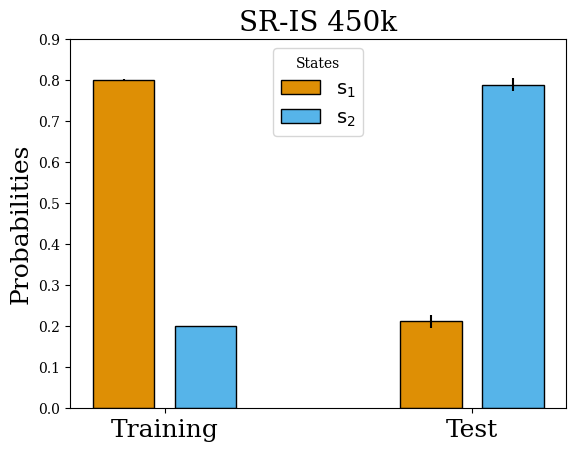

In [ ]:
save_path = save_dir + 'policy_reval_sr_is.png'

prob_train_mean = [np.mean(prob_old_sr_is[0]), np.mean(prob_old_sr_is[1])]
prob_test_mean = [np.mean(prob_new_sr_is[0]), np.mean(prob_new_sr_is[1])]
std_train = [sem(prob_old_sr_is[0]), sem(prob_old_sr_is[1])]
std_test = [sem(prob_new_sr_is[0]), sem(prob_new_sr_is[1])]

plot_decision_prob(
    probs_train=prob_train_mean,
    probs_test=prob_test_mean,
    colors=colors,
    title='SR-IS 450k',
    leg_loc="upper center",
    save_path=None,
    std=[std_train, std_test]
)

#### SR-MB

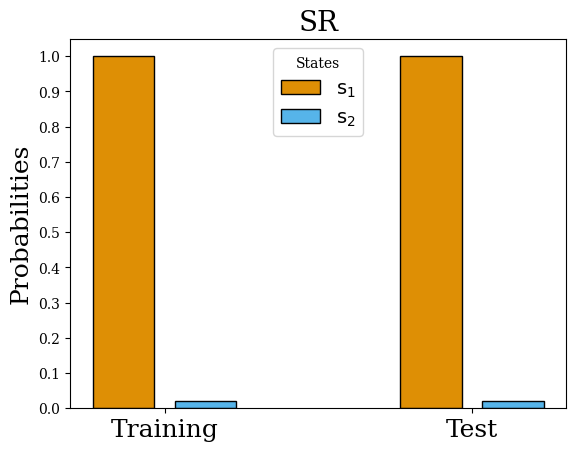

In [ ]:
save_path = save_dir + 'policy_reval_sr_mb.png'

prob_train_mean = [np.mean(prob_old_sr_mb[0]), np.mean(prob_old_sr_mb[1])]
prob_test_mean = [np.mean(prob_new_sr_mb[0]), np.mean(prob_new_sr_mb[1])]
std_train = [sem(prob_old_sr_mb[0]), sem(prob_old_sr_mb[1])]
std_test = [sem(prob_new_sr_mb[0]), sem(prob_new_sr_mb[1])]

plot_decision_prob(
    probs_train=prob_train_mean,
    probs_test=prob_test_mean,
    colors=colors,
    title='SR',
    leg_loc="upper center",
    save_path=None,
    std=[std_train, std_test]
)